# 2D Algorithm Simulation

Includes:

- A 2D room simulation to model recording signals in a real environment
- A variety of implementations of (2D) beamforming algorithms based on the recorded data

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound

### Build Theatre Environment

Create shoebox room of similar size and characteristics to theatre to simulate in.

In [142]:
# build theatre env here

fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # stage width
room_y = 20 # room length
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)

### Place microphones

Defines array geometry and places the microphones near the stage (the front of the room).

In [143]:
# design parameters of array
array_loc = [5, 15] # x/y location of array center
n_mics = 16 # number of microphones
sep = 0.1 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N) # uses omnidirectional mics by default
room.add_microphone_array(mic_array)

### Place sound sources

Sources can be placed anywhere, with two samples placed apart from each other on stage. The 'input_samples' folder contains all input samples, some taken from the pyroomacoustics github.

In [144]:
# Add sources on stage
source_locs = [[3, 19], [7, 19]] # locations of each source in 3D space (can modify)
source_inputs = ['input_samples/singing_8000.wav', 'input_samples/german_speech_8000.wav'] # filepaths to wav files being played by the source

for i in range(len(source_locs)):
    _, audio = wavfile.read(source_inputs[i])
    room.add_source(source_locs[i], signal=audio, delay=0)

### Beamforming Algorithms

 Delay and sum beamformer:

In [119]:
mic_array.rake_delay_and_sum_weights(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1], # this algorithm has no way of accounting for an interferer, but shown for comparison
)
mic_array.filters_from_weights()

out_filepath = 'output_samples/DNS'

MVDR beamformer:

In [127]:
mic_array.rake_mvdr_filters(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1],
    R_n=sigma2_n * np.eye(mic_array.Lg * mic_array.M) # estimated noise covariance matrix
)
out_filepath = 'output_samples/MVDR'

Max SINR beamformer:

In [136]:
mic_array.rake_max_sinr_weights(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1],
    R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
)
mic_array.filters_from_weights()
out_filepath = 'output_samples/MaxSINR'

One Forcing beamformer:

In [145]:
mic_array.rake_one_forcing_weights(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1],
    R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
)
mic_array.filters_from_weights()
out_filepath = 'output_samples/OneForcing'

## Simulation

Performs processing with selected beamforming algorithm above

In [146]:
room.compute_rir()
room.simulate()

# save sound from middle mic as an estimated raw input
raw_mic = pra.normalize(mic_array.signals[mic_array.M // 2])
wavfile.write(out_filepath + '/combined_8000_mic_' + str(mic_array.M // 2) + '.wav', fs, raw_mic)

# save processed sound as output
output = mic_array.process()
out_norm = pra.normalize(output)
wavfile.write(out_filepath + '/combined_8000_processed.wav', fs, out_norm)

## Evaluation

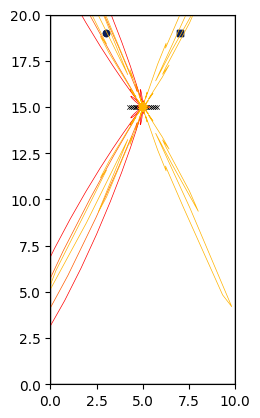

In [147]:
# plot peam pattern
fig, ax = room.plot(freq=[1000, 2000, 4000], img_order=0)

## Play Audio

In [148]:
playsound(out_filepath + '/combined_8000_mic_8.wav')

In [149]:
playsound(out_filepath + '/combined_8000_processed.wav')